<a href="https://colab.research.google.com/github/matteo-filippini/colab/blob/master/decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext tensorboard
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q git+https://github.com/tensorflow/docs

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from scipy.spatial.distance import euclidean

import sys, os
sys.path.insert(0, "/content/drive/My Drive/Colab Notebooks/decoding/supportFunctions")
from plot_confidence_ellipse import confidence_ellipse


print(tf.__version__)

path = "/content/drive/My Drive/Colab Notebooks/decoding/modelli/"

2.2.0


In [0]:
#carico il ds REACH
ds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/decoding/reach_led1_22_bin20.npy.csv",skiprows=[0],dtype='float')
#ds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/decoding/reach_led1_22.npy_delay-620.csv",skiprows=[0],dtype='float')

In [0]:
#carico il ds GRASP
ds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/decoding/grasp_led1_21_bin20.npy.csv",skiprows=[0],dtype='float')
#ds = pd.read_csv("/content/drive/My Drive/Colab Notebooks/decoding/grasp_led1_21.npy_delay-620.csv",skiprows=[0],dtype='float')

In [0]:
#aggiungo colonne XY
X = {0:-2.6,1:0,2:2.6,3:-3.75,4:0,5:3.75,6:-6,7:0,8:6}
Xpos = {x:y+6 for x,y in X.items()}
Y = {0:9.4,1:10,2:9.4,3:14.2,4:15,5:14.2,6:23.4,7:25,8:23.4}
E = {0:0,1:0,2:0,3:1,4:1,5:2,6:0} #per rimappare le epoch con meno classi, da errore se le epoch nn sono 7!
pop = ['epoch','progr_bin','condition','trial']
ds_label = ds[pop]
ds = ds.drop(pop,1)
ds_label['X'] = ds_label['condition'].map(Xpos)
ds_label['Y'] = ds_label['condition'].map(Y)
ds_label['E'] = ds_label['epoch'].map(E)

#normalizzazione su colonne (attività max neurone)
ds = ds.apply(lambda x: x/x.max())
ds_label = ds_label.apply(lambda x: x if x.name in ['epoch', 'condition', 'progr_bin', 'trial','E'] else x/x.max())

#converto in numpy
ds_np = ds.to_numpy()
ds_label_np = ds_label.to_numpy()

In [0]:
ds_label.head()
#ds.describe()

,epoch,progr_bin,condition,trial,E
0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0
2,0.0,2.0,0.0,0.0,0
3,0.0,3.0,0.0,0.0,0
4,0.0,4.0,0.0,0.0,0


In [0]:
#sistema il dataset per time series [[n1b1,n1b2,n1b3,...][n2b1n2b2n2b3,...]]
def sistema_ds(bw, step):  
  #bw n bin per sample
  #step ogni step crea un nuovo sample
  dsc = []
  lbc = []
  for e in np.unique(ds_label_np[:,0]):
    for c in np.unique(ds_label_np[:,2]):
      for t in np.unique(ds_label_np[:,3]):
        mask= np.argwhere((ds_label_np[:,0] == e) & (ds_label_np[:,2] == c) & (ds_label_np[:,3] == t)).squeeze()
        
        tempds = ds_np[mask,:]
        templb = ds_label_np[mask,:]
        #print('epoch ' + str(e) + ' cond ' + str(c) + ' trial ' + str(t) + ' ha ' + str(tempds.shape[0]) + ' bins' )
        for b in range(0,tempds.shape[0],step):
          
          trial = []
          if b+bw < tempds.shape[0]:
            for f in range(tempds.shape[1]):
              trial.append(tempds[b:b+bw,f])
            dsc.append(trial)    
            lbc.append(templb[b+bw,:])
  #import pdb; pdb.set_trace()
  dsc = np.asarray(dsc).transpose(0,2,1)
  lbc = np.asarray(lbc)
  return dsc, lbc


In [0]:
# [[['S-KeyDown', -1000, 'S-KeyDown', 0], ['S-KeyDown', 0, 'LED1', 0], ['LED1', 0, 'Task', 0], ['Task', 0, 'KeyUp', 0], ['KeyUp', 0, 'TOUCH1', 0], ['TOUCH1', 0, 'TOUCH2', 0], ['TOUCH2', 0, 'T-KeyD', 0]], {0: 10, 1: 10, 2: 19, 3: 2, 4: 4, 5: 12, 6: 2}, 100, 20]
#decidere qui se regressione o classificazione

gridsearch1 = {'arch':'dnn','tipo':'classificazione',
              'n_spilts':5, #split per crossval,
              'n_layers':(1,3,5,10),
              'n_neurons_per_layer':(50,100,150),
              'dropout':(0,0.25,0.5,0.75),
              'regularizer':(0.01, 0.001, 0.0002),
              'name':'grid1',
              'n_bin_per_sample':5,
              'step':3}

gridsearch_dnn = {'arch':'dnn','tipo':'classificazione',
                  'n_spilts':5, #split per crossval,
                  'n_layers':[1],
                  'n_neurons_per_layer':[50], #in cnn è il n filtri
                  'dropout':[0.5],
                  'regularizer': [0.0002],
                  'name':'dnn_1_50_.5_.0002',
                  'n_bin_per_sample':5,
                  'step':3}

gridsearch_cnn = {'arch':'cnn','tipo':'classificazione',
                  'n_spilts':5, #split per crossval,
                  'n_layers':[1],
                  'n_neurons_per_layer':[64], #in cnn è il n filtri
                  'dropout':[0.5],
                  'regularizer': [0.0002],
                  'name':'cnn_1_64_.5_.0002',
                  'n_bin_per_sample':15,
                  'step':3}
gridsearch_rnn = {'arch':'rnn','tipo':'classificazione',
                  'n_spilts':5, #split per crossval,
                  'n_layers':[0],
                  'n_neurons_per_layer':[100],
                  'dropout':[0.5],
                  'regularizer': [0.0002],
                  'name':'rnn_1_64_.5_.0002',
                  'n_bin_per_sample':15,
                  'step':3}

gridsearch = gridsearch_rnn
bw = gridsearch['n_bin_per_sample']
step = step=gridsearch['step']
dsc, lbc = sistema_ds(bw=bw, step=step)  

dsc.shape

#tipo = 'regrclass'
#n_splits= 5 #split per crossval
tipo = gridsearch['tipo']

#filtra epoch di interesse
epoch = [2,3,4,5] #da delay a hold
#epoch = [2]
idx = [idx for idx, label in enumerate(lbc) if label[0] in epoch]
dataset = dsc[idx]
labels_raw = lbc[idx]
labels = lbc[idx] #questo viene filtrato sotto con le sole features utili

#separo i dataset train e test
idxtrain = []
idxtest = []

from sklearn.model_selection import KFold
kf = KFold(gridsearch['n_spilts'])
for train_index, test_index in kf.split([0,1,2,3,4,5,6,7,8,9]):
  idxtrain.append([idx for idx, x in enumerate(labels) if x[3] in train_index])
  idxtest.append([idx for idx, x in enumerate(labels) if x[3] in test_index])
#np.random.permutation(idxtrain) #randomizza i sample

#scelgo colonne target guarda colonne in ds_label.head()
if tipo == 'classificazione':
  features= 2 #2 posizioni pannello, 0 o 6 epochs
  n_out_C = len(np.unique(lbc[:,features])) #n classi
  weightC = {id: value for id, value in enumerate(compute_class_weight(class_weight= 'balanced', classes=np.unique(labels[:,features]),y=labels[:,features]))} #per calcolare le classi unbalanced
  weightL = None
  #labels = labels[:,features]
  labels = np.eye(n_out_C)[labels[:,features].astype(int)] #trasforma in one hot (nn serve con sparse_)
elif tipo == 'regressione':
  features=[4,5]
  n_out_R = len(features) #x,y
  weightL = ''
  weightC = ''
elif tipo == 'regrclass':
  features=[[4,5],[6]]
  n_out_C = len(np.unique(lbc[:,features[1]]))
  n_out_R = len(features[0])
  weightL = {'regre':2,'classi':0.5} #bilanciamento output, empirico
  weightC = {'classi':{id: value for id, value in enumerate(compute_class_weight(class_weight= 'balanced', classes=np.unique(labels[:,features[1][0]]),y=labels[:,features[1][0]]))}} 



In [0]:
np.mean(idxtest[0])
weightC
labels.shape
print(labels_raw)

[[ 2.          5.          0.         ...  0.28333333  0.376
   0.        ]
 [ 2.          8.          0.         ...  0.28333333  0.376
   0.        ]
 [ 2.         11.          0.         ...  0.28333333  0.376
   0.        ]
 ...
 [ 5.         53.          8.         ...  1.          0.936
   2.        ]
 [ 5.         56.          8.         ...  1.          0.936
   2.        ]
 [ 5.         59.          8.         ...  1.          0.936
   2.        ]]


In [0]:
#modello

def modello(arch='dnn', tipo='regressione', n_layers = 1, n_neurons_per_layer = 100, dropout = 0, regularizer = 0.0002):
  inputs = keras.Input(shape= (bw, dsc.shape[2]))

  if arch == 'dnn':
    x = layers.Dense(150, activation='relu', kernel_regularizer=regularizers.l2(regularizer))(inputs)
    #x = layers.Flatten('channels_first')(x) #per collassare dimensione n bin
    for l in range(n_layers):
      x = layers.Dense(n_neurons_per_layer, activation='relu', kernel_regularizer=regularizers.l2(regularizer))(x)
      #x = layers.BatchNormalization()(x)
      x = layers.Dropout(dropout)(x)
    x = layers.Flatten('channels_first')(x) #per collassare dimensione n bin
    
    if tipo =='regrclass':
      regre = layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(regularizer))(x)
      regre = layers.Dropout(dropout)(regre)
      #regre = layers.BatchNormalization()(regre)

      classi = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(regularizer))(x)
      classi = layers.Dropout(dropout)(classi)
      #classi = layers.BatchNormalization()(classi)

  elif arch == 'cnn':
      #import pdb; pdb.set_trace()
      #https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
      x = layers.Conv1D(filters=n_neurons_per_layer, kernel_size=3, activation='relu', input_shape=(bw, dsc.shape[2]))(inputs)
      x = layers.Conv1D(filters=n_neurons_per_layer, kernel_size=3, activation='relu')(x)
      x = layers.MaxPooling1D(pool_size=2)(x)
      x = layers.Conv1D(filters=n_neurons_per_layer, kernel_size=3, activation='relu')(x)
      x = layers.Conv1D(filters=n_neurons_per_layer, kernel_size=3, activation='relu')(x)
      x = layers.GlobalAveragePooling1D()(x)
      x = layers.Dropout(dropout)(x)

  elif arch == 'rnn':
      #x = layers.GRU(n_neurons_per_layer, return_sequences=True, input_shape=(bw, dsc.shape[2]),recurrent_dropout=dropout)(inputs)
      x = layers.GRU(n_neurons_per_layer, input_shape=(bw, dsc.shape[2]),recurrent_dropout=dropout)(inputs)
      for l in range(n_layers): #nn va
        x = layers.GRU(n_neurons, return_sequences=True,dropout=dropout)(x)
      #regre = layers.GRU(50, dropout=0.2)(x)
      #classi = layers.GRU(50, dropout=0.2)(x)

  if tipo == 'regressione':
    regre = layers.Dense(n_out_R, name='regre')(regre)
    model = keras.Model(inputs,regre)
  elif tipo == 'regrclass':
    regre = layers.Dense(n_out_R, name='regre')(regre)
    classi = layers.Dense(n_out_C, activation = 'softmax', name='classi')(classi)
    model = keras.Model(inputs,[regre, classi])
  elif tipo == 'classificazione':
    classi = layers.Dense(n_out_C, activation='softmax', name='classi')(x)
    model = keras.Model(inputs,classi)
  
  return model


In [0]:
optimizer = 'adam'
#optimizer = tf.keras.optimizers.RMSprop(0.001)

#metrics
if tipo == 'regressione':
  monitor='val_mean_squared_error'
  loss='mse'
  metrics=['mae', 'mse']
  metric = 'mean_absolute_error' #per plot
elif tipo == 'classificazione':
  monitor='val_loss'
  loss='categorical_crossentropy'
  metrics=['categorical_accuracy','Precision','Recall']
  metric = 'categorical_accuracy' #per plot
elif tipo == 'regrclass':
  monitor='val_loss'
  loss = {'regre':'mse','classi':'sparse_categorical_crossentropy'} 
  metrics={'regre':'mse','classi':'accuracy'}
  metric = 'mean_absolute_error'


#definizione callbacks
early_stop = keras.callbacks.EarlyStopping(monitor=monitor, patience=500)
checkpoint = keras.callbacks.ModelCheckpoint(path + 'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor=monitor, verbose=0, save_best_only=True, mode='auto')
history = []

#fit function
def fit(g, idtrain, idtest, n, k):
  model = modello(arch=gridsearch['arch'], tipo=tipo, n_layers = g[0], n_neurons_per_layer = g[1], dropout = g[2], regularizer = g[3])
  #import pdb; pdb.set_trace()
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights = weightL)
  
  model.fit(dataset[idtrain], labels[idtrain], epochs=20000,
                      #validation_split = 0.25, 
                      validation_data = (dataset[idtest], labels[idtest]), #uso il ds di test per validare ho pochi trials ;_;
                      verbose=0,
                      class_weight = weightC,
                      callbacks=[early_stop,
                                #checkpoint,
                                tfdocs.modeling.EpochDots(),
                                tf.keras.callbacks.TensorBoard(path + "logdir/" + gridsearch['name'] + "_" + str(n))]
                           )
  model.save(path + gridsearch['name'] + '_' + str(n) + '_' + str(k) + '.h5')
  model = []
  return model



In [0]:
#%tensorboard --logdir "/content/drive/My Drive/Colab Notebooks/decoding/modelli/logdir/"
#fitting
grid = product(gridsearch['n_layers'],gridsearch['n_neurons_per_layer'],gridsearch['dropout'],gridsearch['regularizer'])
for n, g in enumerate(grid):
  print('#{} n_layers {} n_neurons_per_layer {} dropout {} regularizer {}'.format(n, *g))
  #if n < 136: continue
  for k in range(gridsearch['n_spilts']):
    #if k < 2: continue
    fit(g, idxtrain[k], idxtest[k], n, k)
    

In [0]:
#grid evaluate
grid_res = []
grid = product(gridsearch['n_layers'],gridsearch['n_neurons_per_layer'],gridsearch['dropout'],gridsearch['regularizer'])
for n, g in enumerate(grid):
  print('#{} n_layers {} n_neurons_per_layer {} dropout {} regularizer {}'.format(n, *g))
  for k in range(gridsearch['n_spilts']):
    if k > 2: break
    print('n° CV {}'.format(k))
    nomefile = path + gridsearch['name'] + '_' + str(n) + '_' + str(k) + '.h5'
    if os.path.exists(nomefile):
      model = keras.models.load_model(path + gridsearch['name'] + '_' + str(n) + '_' + str(k) + '.h5')
      grid_res.append([n, k, *g, *model.evaluate(dataset[idxtest[k]], labels[idxtest[k]],verbose=1)])
    else:
      print('file non trovato')

col_classi = ['n','CV','n_layers','n_neurs','dropout','regularizer','loss','accuracy','precision','recall']
res = pd.DataFrame(data=np.asarray(grid_res),columns=col_classi)
res.to_csv(path + gridsearch['name'] + '_results.csv')
res.describe()

In [0]:
#res = pd.read_csv(path + gridsearch['name'] + '_results.csv')
#res.corr()
res = pd.read_csv(path + 'grid1_reach/' + 'grid1_results.csv')
res.sort_values('accuracy',ascending=False).head()

,Unnamed: 0,n,CV,n_layers,n_neurs,dropout,regularizer,loss,accuracy,precision,recall
1,1,0.0,1.0,1.0,50.0,0.00,0.010,0.998950,0.746704,0.818475,0.717514
94,94,31.0,1.0,1.0,150.0,0.50,0.001,1.169058,0.740113,0.784114,0.725047
20,20,6.0,2.0,1.0,50.0,0.50,0.010,0.983113,0.738230,0.801715,0.704331
22,22,7.0,1.0,1.0,50.0,0.50,0.001,1.078741,0.733522,0.769386,0.719397
64,64,21.0,1.0,1.0,100.0,0.75,0.010,1.051828,0.733522,0.817881,0.697740


In [0]:
#plotta metric vs training epochs (per comodità plotto solo il primo modello cv)
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history[0]}, metric = metric)
plt.ylim([0, 0.3])
plt.ylabel('XY')
loss, mae, mse = models[0].evaluate(dataset[idxtest[0]], labels[idxtest[0],feature_start:feature_stop], verbose=2)
print("Testing set XY value MAE:{:5.2f}  MSE:{:5.2f}".format(mae,mse))

In [0]:
#predici 
n = 0 #combinazione itertool, mettere a mano
result = [] #tiene separati epoch e bin
nbin = []
for s in range(gridsearch['n_spilts']):
  result_cv = []
  model = keras.models.load_model(path + gridsearch['name'] + '_' + str(n) + '_' + str(s) + '.h5')
  for e in epoch:
    idxE = [idx for idx, x in enumerate(labels_raw) if (idx in idxtest[s]) & (x[0] == e)]
    #import pdb; pdb.set_trace()
    for b in np.unique(labels_raw[idxE,1]):
      idxB = [idx for idx, x in enumerate(labels_raw) if (idx in idxE) & (x[1] == b)]
      print('prediction CV #{} epoch #{} bin #{}'.format(s,e,b))
      predictions = model.predict(dataset[idxB], verbose=1)
      real = labels[idxB] #X,Y vero
      clas = labels_raw[idxB,2] #posizione pannello/oggetto
      epoch_real = labels_raw[idxB,6] #epoch rimappata
      if tipo == 'regressione':
        R2 = r2_score(real, predictions, multioutput='variance_weighted')
        result_cv.append([predictions,real,clas,R2,epoch_real,[]])
      elif tipo == 'classificazione':
        R2 = []
        result_cv.append([np.argmax(predictions, axis=1),np.argmax(real, axis=1),clas,R2,epoch_real,[]])
      elif tipo == 'regrclass':
        result_cv.append([predictions[0],real,clas,R2,epoch_real,np.argmax(predictions[1],1)])
      
  result.append(result_cv) #[split][epoch][prediction/real/class/r2/epoch_real/epoch_predicted][bin,x:y]

np.save(path + gridsearch['name'], result)

prediction CV #0 epoch #2 bin #15.0
1/1 [==============================] - 0s 1ms/step
prediction CV #0 epoch #2 bin #18.0
1/1 [==============================] - 0s 735us/step
prediction CV #0 epoch #2 bin #21.0
1/1 [==============================] - 0s 688us/step
prediction CV #0 epoch #2 bin #24.0
1/1 [==============================] - 0s 732us/step
prediction CV #0 epoch #2 bin #27.0
1/1 [==============================] - 0s 677us/step
prediction CV #0 epoch #2 bin #30.0
1/1 [==============================] - 0s 746us/step
prediction CV #0 epoch #2 bin #33.0
1/1 [==============================] - 0s 666us/step
prediction CV #0 epoch #2 bin #36.0
1/1 [==============================] - 0s 706us/step
prediction CV #0 epoch #2 bin #39.0
1/1 [==============================] - 0s 826us/step
prediction CV #0 epoch #2 bin #42.0
1/1 [==============================] - 0s 699us/step
prediction CV #0 epoch #2 bin #45.0
1/1 [==============================] - 0s 719us/step
prediction CV #0 epoch 

In [0]:
#ricarica i dati
result = np.load(path + gridsearch['name'] + '.npy', allow_pickle=True)

In [0]:
#plotta grafico tempoxR2 mantengo separate le CV
#np.save(path + "dnn20ms", result)
result_np = np.asarray(result)
for s in range(n_splits):
  plt.plot(result_np[s,:,3])
plt.xlabel('progressivo bin')
plt.ylabel('R^2')
#plt.xlim([0,1])
plt.ylim([0,1])

ValueError: ignored

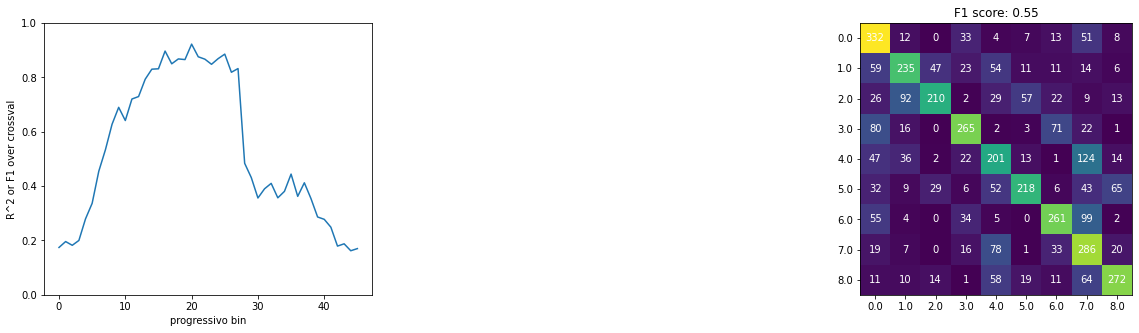

In [0]:
#PLOTTA I RISULTATI

#collasso la dimensione splits
result_np = np.asarray(result)
predictionsXY= []
realXY = []
realclass = []
R2 = []
epoch_real = []
epoch_pred = []
for b in range(result_np.shape[1]):
  predictionsXY.append(np.vstack(result_np[:,b,0]))
  realXY.append(np.vstack(result_np[:,b,1]))
  realclass.append(np.vstack(result_np[:,b,2]).flatten())
  #import pdb; pdb.set_trace()
  if tipo == 'classificazione':
    R2.append(f1_score(realXY[-1].flatten(), predictionsXY[-1].flatten(), average='weighted'))
  else:
    R2.append(r2_score(realXY[-1], predictionsXY[-1], multioutput='variance_weighted'))
  epoch_real.append(np.vstack(result_np[:,b,4]).flatten())
  epoch_pred.append(np.vstack(result_np[:,b,5]).flatten())

plt.figure(figsize=(20,5))

#plotto r2 sul tempo
plt.subplot(1,3,1)
plt.plot(np.hstack(R2))
plt.xlabel('progressivo bin')
plt.ylabel('R^2 or F1 over crossval')
#plt.xlim([0,1])
plt.ylim([0,1])

#collasso la dimensione bins
predXY = np.vstack(predictionsXY)
rXY = np.vstack(realXY)
rc = np.hstack(realclass)
epocR = np.hstack(epoch_real)
epocP = np.hstack(epoch_pred)

if not tipo == 'classificazione':
  #import pdb; pdb.set_trace()
  #plotto XvsY
  axes = plt.subplot(1,3,2)
  plt.scatter(predXY[:,0], predXY[:,1], c=[x/8 for x in rc])
  plt.scatter(rXY[:,0], rXY[:,1], c=[x/8 for x in rc], marker='x', s=2000)
  plt.xlabel('Predictions [X]')
  plt.ylabel('Predictions [Y]')
  plt.xlim([0,1])
  plt.ylim([0.3,1])

  centroids = []
  for c in np.unique(rc):
    idx = [idx for idx, cla in enumerate(rc) if cla == c]
    confidence_ellipse(predXY[idx,0],predXY[idx,1],axes, n_std= 1, edgecolor='red')
    centroids.append([c, np.mean(predXY[idx,0]), np.std(predXY[idx,0]), 
                      np.mean(predXY[idx,1]), np.std(predXY[idx,1]),
                      rXY[idx[0],0],rXY[idx[0],1],
                      euclidean([rXY[idx[0],0],rXY[idx[0],1]],[np.mean(predXY[idx,0]),np.mean(predXY[idx,1])])])
                      #[posizione, Xmean_pred, Xstd, Ymean_pred, Ystd, X real, Yreal, distanza real/centroid predetto]
else:
  CM = confusion_matrix(rXY.flatten(), predXY.flatten())
  ax = plt.subplot(1,3,3)
  im = ax.imshow(CM)
  tags = np.unique(rc)
  # We want to show all ticks...
  ax.set_xticks(np.arange(len(tags)))
  ax.set_yticks(np.arange(len(tags)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(tags)
  ax.set_yticklabels(tags)
  # Loop over data dimensions and create text annotations.
  for i in range(len(tags)):
      for j in range(len(tags)):
          text = ax.text(j, i, CM[i, j],
                        ha="center", va="center", color="w")    
  ax.set_title('F1 score: '+ str(round(f1_score(rXY.flatten(), predXY.flatten(),average='weighted'),2)))  

#plotto CM
CM = confusion_matrix(epocR, epocP)
ax = plt.subplot(1,3,3)
im = ax.imshow(CM)
tags = ["PLAN", "MOV", "HOLD"]
# We want to show all ticks...
ax.set_xticks(np.arange(len(tags)))
ax.set_yticks(np.arange(len(tags)))
# ... and label them with the respective list entries
ax.set_xticklabels(tags)
ax.set_yticklabels(tags)
# Loop over data dimensions and create text annotations.
for i in range(len(tags)):
    for j in range(len(tags)):
        text = ax.text(j, i, CM[i, j],
                       ha="center", va="center", color="w")    
ax.set_title('F1 score: '+ str(round(f1_score(epocR,epocP,average='weighted'),2)))
plt.show()

In [0]:
#PLOTTA IL RISULTATO BIN X BIN
import ipywidgets as widgets
modello = 0

def f(x):
  axes = plt.subplot()
  predXY = []
  realXY = []
  rc = []
  epochR = []
  epochP = []
  for s in result:
    predXY.append(s[x][0])
    realXY.append(s[x][1])
    rc.append(s[x][2])
    epochR.append(s[x][4])
    epochP.append(s[x][5])
  predXY = np.vstack(predXY)
  realXY = np.vstack(realXY)
  rc = np.hstack(rc)
  epochR = np.hstack(epochR)
  epochP = np.hstack(epochP)

  plt.scatter(predXY[:,0], predXY[:,1], c=[x/8 for x in rc])
  plt.scatter(realXY[:,0], realXY[:,1], c=[x/8 for x in rc], marker='x', s=2000)
  for c in np.unique(rc):
    idx = [idx for idx, cla in enumerate(rc) if cla == c]
    confidence_ellipse(predXY[idx,0],predXY[idx,1],axes, n_std= 1, edgecolor='red')
  plt.xlabel('Predictions [X]')
  plt.ylabel('Predictions [Y]')
  plt.xlim([0,1])
  plt.ylim([0.3,1])
  print('R2: ' + str(round(r2_score(realXY, predXY, multioutput='variance_weighted'),2)) + 
        ' classe reale: ' + str(np.unique(epochR)) + ' predetta corretta al: ' + 
        str(round(np.sum(epochR == epochP)/len(epochR),2)))


widgets.interact(f, x=widgets.IntSlider(min=0, max=len(result[0])-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=58), Output()), _dom_classes=('widget-interact',…